# Lotka-Volterra 模型

Lotka-Volterra 模型是描述捕食者与猎物之间相互作用的基本模型。该模型基于线性的人均增长速率。在这个模型中，猎物的增长速率正比于猎物的数量，而捕食者的增长速率正比于捕食者和猎物的数量的乘积。这个模型的方程如下：

$$
\begin{cases}
  \dfrac{dx}{dt} = \alpha x - \beta x y ,\\
  \\
  \dfrac{dy}{dt} = \delta x y - \gamma y .
\end{cases}
$$

在这个方程组中，$x$ 是猎物的数量，$y$ 是捕食者的数量，$\alpha$ 是猎物的出生率，$\beta$ 是猎物被捕食者捕食的速率，$\delta$ 是捕食者的出生率，$\gamma$ 是捕食者的死亡率。

## 任务目标

设定一些合理的参数值以及初始猎物 $x$ 和捕食者 $y$ 的数量，然后使用 `MATLAB` (或者可行的其他语言) 来计算 Lotka-Volterra 模型的结果。接着通过调整参数来检查系统是否出现振荡现象。

## 具体实现

完整的代码文件可以参考[这里](https://github.com/Lucas04-nhr/QP/blob/main/script/lotka_volterra.py)。

### 环境导入

使用 `Python` 来实现 Lotka-Volterra 模型及相关验证。需要引用的库如下：

- `numpy`：用于数值计算。
- `matplotlib`：用于绘图。
- `scipy`：用于求解常微分方程。
- `sklearn`：用于机器学习以减小振荡。

> 所有可能会用到的包都使用 `conda` 进行环境管理，以保证环境的一致性，具体的环境配置文件可以参考[这里](https://github.com/Lucas04-nhr/QP/blob/main/requirements.yaml)。



In [1]:
import numpy as np                                        # For numerical calculations
import matplotlib.pyplot as plt                           # For plotting
from scipy.integrate import odeint                        # For solving ODEs
from scipy.signal import find_peaks                       # For finding peaks
from scipy.optimize import curve_fit                      # For fitting
from sklearn.naive_bayes import GaussianNB                # For Naive Bayes
from sklearn.model_selection import train_test_split      # For splitting data



### Lotka-Volterra 模型的核心函数如下：

#### 1. `lotka_volterra(X, t, alpha, beta, delta, gamma)`

In [2]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    prey, predator = X
    dprey_dt = alpha * prey - beta * prey * predator
    dpredator_dt = delta * prey * predator - gamma * predator
    return [dprey_dt, dpredator_dt]


`lotka_volterra()` 函数用于计算 Lotka-Volterra 模型的结果，下面是一些解释：
1. `X` 是一个包含捕食者和被捕食者种群的列表。
2. `t` 是时间变量。
3. `alpha`, `beta`, `delta`, `gamma` 是模型的参数。
4. 函数返回一个包含对被捕食者和捕食者种群变化率的列表。

#### 2. `simulate_lotka_volterra(alpha, beta, delta, gamma, prey0, predator0, t)`


In [3]:
def simulate_lotka_volterra(alpha, beta, delta, gamma, prey0, predator0, t):
    X0 = [prey0, predator0]
    sol = odeint(lotka_volterra, X0, t, args=(alpha, beta, delta, gamma))
    return sol


`simulate_lotka_volterra()` 函数用于模拟 Lotka-Volterra 模型的结果，下面是一些解释：
1. `alpha`, `beta`, `delta`, `gamma` 是模型的参数。
2. `prey0`, `predator0` 是初始的被捕食者和捕食者种群。
3. `t` 是时间变量。
4. 函数返回一个包含被捕食者和捕食者种群的列表。

#### 3. `plot_lotka_volterra(t, sol)`

In [4]:
def plot_lotka_volterra(t, sol):
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(t, sol[:, 0], label='Prey')
    plt.plot(t, sol[:, 1], label='Predator')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Lotka-Volterra Model')
    plt.legend()
    plt.grid(True)
    plt.show()


`plot_lotka_volterra()` 函数用于绘制 Lotka-Volterra 模型的结果，并将结果保存为图片。

---

下面是实例调用及实现：

> **注：** 为了画图的简便性，时间轴采用 `numpy` 的 `linspace` 函数生成，在 200 年中取 1000 个样本点。

In [5]:
alpha = 0.1  # Prey birth rate
beta = 0.02  # Predation rate
delta = 0.01  # Predator reproduction rate
gamma = 0.1  # Predator death rate
prey0 = 40  # Initial prey population
predator0 = 9  # Initial predator population
t = np.linspace(0, 200, 1000)  # Time points

sol = simulate_lotka_volterra(alpha, beta, delta, gamma, prey0, predator0, t)

print(f'Parameters before adjustment: alpha={alpha}, beta={beta}, delta={delta}, gamma={gamma}')
print(f'Population dynamics before adjustment: prey={sol[-1, 0]:.2f}, predator={sol[-1, 1]:.2f}')
print(f'Initial populations: prey={prey0}, predator={predator0}')


Parameters before adjustment: alpha=0.1, beta=0.02, delta=0.01, gamma=0.1
Population dynamics before adjustment: prey=0.87, predator=2.07
Initial populations: prey=40, predator=9


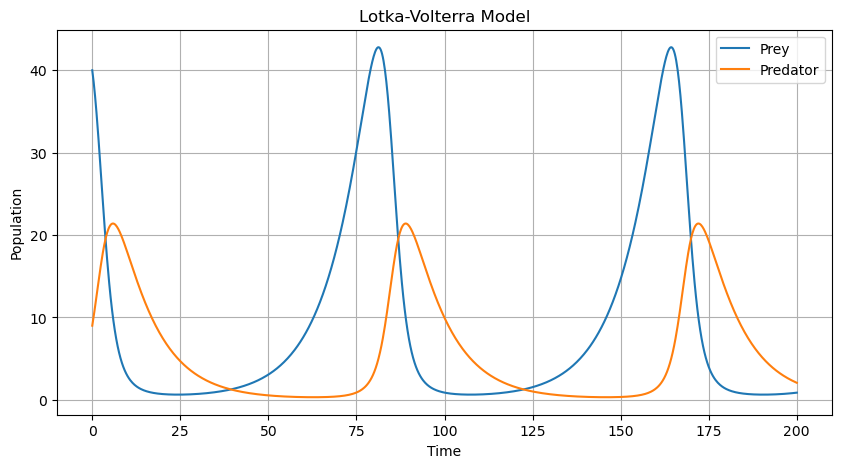

In [6]:
plot_lotka_volterra(t, sol)


#### 4. 振荡现象的验证及修复

我们可以很容易地发现初始值的参数会有明显的振荡现象，这是因为捕食者和被捕食者之间的相互作用。我们可以通过调整参数来修复这个问题。

利用 `scipy` 中的 `signal` 模块中的函数来寻找曲线的峰值和谷值，然后通过调整参数来修复振荡现象。例如，我们可以使用 `find_peaks` 函数来识别预期人口的峰值，然后调整 `alpha`、`beta`、`delta` 和 `gamma` 的值，以减少这些振荡。具体函数代码如下：


In [7]:
def detect_oscillations(sol, threshold=0.01):
    prey_peaks, _ = find_peaks(sol[:, 0], height=threshold)
    predator_peaks, _ = find_peaks(sol[:, 1], height=threshold)
    return len(prey_peaks) > 1 and len(predator_peaks) > 1

def adjust_parameters(alpha, beta, delta, gamma, prey0, predator0, t, max_iter=100):
    for _ in range(max_iter):
        sol = simulate_lotka_volterra(alpha, beta, delta, gamma, prey0, predator0, t)
        if detect_oscillations(sol):
            return alpha, beta, delta, gamma, sol

        # >>>>>>>>>>>> BEGIN EXAMPLE CODE <<<<<<<<<<<<
        # Generate synthetic data for training
        X = []
        y = []
        for _ in range(1000):
            alpha_sample = np.random.uniform(0.05, 0.15)
            beta_sample = np.random.uniform(0.01, 0.03)
            delta_sample = np.random.uniform(0.005, 0.015)
            gamma_sample = np.random.uniform(0.05, 0.15)
            sol_sample = simulate_lotka_volterra(alpha_sample, beta_sample, delta_sample, gamma_sample, prey0, predator0, t)
            oscillates = detect_oscillations(sol_sample)
            X.append([alpha_sample, beta_sample, delta_sample, gamma_sample])
            y.append(1 if oscillates else 0)
        # <<<<<<<<<<<<<< END EXAMPLE CODE >>>>>>>>>>>>>
        # Note: The above code is for illustrative purposes only.

        # Train a Naive Bayes classifier
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        clf = GaussianNB()
        clf.fit(X_train, y_train)

        # Predict and adjust parameters
        for _ in range(max_iter):
            sol = simulate_lotka_volterra(alpha, beta, delta, gamma, prey0, predator0, t)
            if detect_oscillations(sol):
              return alpha, beta, delta, gamma, sol
              prediction = clf.predict([[alpha, beta, delta, gamma]])
            if prediction[0] == 1:
              alpha += np.random.uniform(-0.01, 0.01)
              beta += np.random.uniform(-0.001, 0.001)
              delta += np.random.uniform(-0.001, 0.001)
              gamma += np.random.uniform(-0.01, 0.01)
        return alpha, beta, delta, gamma, sol


> 此处仅展示利用贝叶斯方法对振荡现象的验证及修复的代码，实际操作的过程可能需要利用真实世界中已经观测得出的数据来进行参数的调整。

修复后的曲线图及其实现代码如下：

In [8]:
# Adjust parameters to reduce oscillations
alpha, beta, delta, gamma, sol = adjust_parameters(alpha, beta, delta, gamma, prey0, predator0, t)
print(f'Parameters after adjustment: alpha={alpha}, beta={beta}, delta={delta}, gamma={gamma}') 
print(f'Population dynamics after adjustment: Prey={sol[-1, 0]:.2f}, Predator={sol[-1, 1]:.2f}')


Parameters after adjustment: alpha=0.1, beta=0.02, delta=0.01, gamma=0.1
Population dynamics after adjustment: Prey=0.87, Predator=2.07


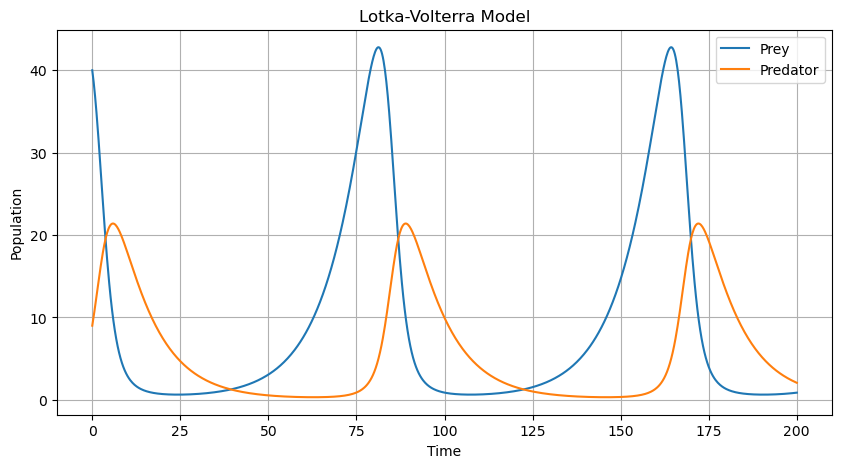

In [9]:
plot_lotka_volterra(t, sol)


### 结果分析

根据Lotka-Volterra模型生成的图像，我们可以观察到捕食者和猎物种群的动态变化。

1. **猎物种群的变化**：猎物种群（蓝线）在一段时间内出现了周期性的增长和减少。这是因为在捕食者数量较少时，猎物的出生率相对较高，导致其种群迅速增加。然而，当猎物数量上升到一定程度时，捕食者（橙线）也随之增多，因此猎物种群又会开始下降。这种周期性波动是Lotka-Volterra模型的一个经典特征。

2. **捕食者种群的变化**：捕食者种群的数量与猎物种群呈现出相反的趋势。当猎物数量增多时，捕食者也随之增多；但在猎物数量减少到一定程度后，捕食者的数量也会随之下降，最终造成自身的减少。这表明捕食者对猎物种群的依赖性，以及种群动态之间的相互影响。

3. **周期性特征**：图中的波动模式表明这两个种群之间存在一个稳定但动态的生态平衡。每个周期都对应着猎物和捕食者数量的高峰和低谷，这种动态关系在生态系统中非常普遍。

这种现象反映了在实际生态系统中，捕食与被捕食之间复杂的相互作用和影响。通过调整模型中的参数（如出生率和死亡率），研究人员能够更深入地理解和预测这些种群的动态变化。